# Import Libraries

In [ ]:
# For drive access
from google.colab import drive
drive.mount('/content/drive')

# Standard libraries
import numpy as np
import pandas as pd

# for loading the pickle files with features and labels
import pickle

# For audio
from IPython.display import Audio
import librosa

# For modeling
import tensorflow as tf
from sklearn.metrics import classification_report

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load feature pickle files (MEL ONLY)

TODO:
- higher quality audio = higher weights

In [ ]:
import pickle
#with open('/content/drive/MyDrive/SYDE 577/BirdClef Models/data/logmel_features_mels_64.pkl', 'rb') as f:
#with open('/content/drive/MyDrive/SYDE 577/BirdClef Models/data/combine_logmel_features_augmented.pkl', 'rb') as f:
with open('/content/drive/MyDrive/SYDE 577/BirdClef Models/data/features_rms.pkl', 'rb') as f:
    data = pickle.load(f)

X_data = data['X']
y_labels = data['y']

#print the data
print(f" Data loaded")
print(f"   Features shape: {X_data.shape}")
print(f"   Labels shape: {y_labels.shape}")
print(f"   Number of samples: {len(X_data)}")

# print out species
unique_species = np.unique(y_labels)
num_species = len(unique_species)
print(f"   Number of bird species: {num_species}")
print(f"   Species: {list(unique_species[:10])}")

#encode labels to numbers
print("\n Encoding labels to numbers...")
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)

print(f" Labels encoded!")
print(f"   Example: '{y_labels[0]}' → {y_encoded[0]}")

 Data loaded
   Features shape: (4727, 2)
   Labels shape: (4727,)
   Number of samples: 4727
   Number of bird species: 10
   Species: ['barswa', 'cohmar1', 'combuz1', 'comsan', 'eaywag1', 'eubeat1', 'hoopoe', 'thrnig1', 'wlwwar', 'woosan']

 Encoding labels to numbers...
 Labels encoded!
   Example: 'barswa' → 0


In [ ]:
train_results = {}
val_results = {}

classes = ['barswa', 'cohmar1', 'combuz1', 'comsan', 'eaywag1', 'eubeat1', 'hoopoe', 'thrnig1', 'wlwwar', 'woosan']

# the code

In [ ]:
#normalize
X_reshaped = X_data.reshape(X_data.shape[0], X_data.shape[1], 1)
print(f" Reshaped from {X_data.shape} to {X_reshaped.shape}")
print(f"   → {X_reshaped.shape[0]} samples")
print(f"   → {X_reshaped.shape[1]} timesteps")
print(f"   → {X_reshaped.shape[2]} feature per timestep")

# Normalize data
mean = np.mean(X_reshaped)
std = np.std(X_reshaped)
X_normalized = (X_reshaped - mean) / std

print(f"   Mean: {np.mean(X_normalized):.6f}")
print(f"   Std: {np.std(X_normalized):.6f}")

 Reshaped from (4727, 2) to (4727, 2, 1)
   → 4727 samples
   → 2 timesteps
   → 1 feature per timestep
   Mean: 0.000000
   Std: 1.000000


In [ ]:
#train/validation/test split



# Train/Test Split
print("\n Splitting into train/test sets...")

X_train, X_test, y_train, y_test = train_test_split(
    X_normalized,
    y_encoded,
    test_size=0.3,
    random_state=42,
    stratify=y_encoded  # Keep class distribution balanced
)

X_val, X_test, y_val, y_test = train_test_split(
    X_test,
    y_test,
    test_size=0.5,
    random_state=42,
    stratify=y_test  # Keep class distribution balanced
)


print(f"   Training samples: {len(X_train)} ({len(X_train)/len(X_normalized)*100:.1f}%)")
print(f"   Validation samples: {len(X_val)} ({len(X_val)/len(X_normalized)*100:.1f}%)")
print(f"   Testing samples: {len(X_test)} ({len(X_test)/len(X_normalized)*100:.1f}%)")
(X_train.shape, X_val.shape, X_test.shape)


 Splitting into train/test sets...
   Training samples: 3308 (70.0%)
   Validation samples: 709 (15.0%)
   Testing samples: 710 (15.0%)


((3308, 2, 1), (709, 2, 1), (710, 2, 1))

In [ ]:


# GRU Model

#todo: add audio features as a parameter here

def build_model(learning_rate=0.002,
                gru=256,
                hidden=[256,128,48],
                dropout=0.3):
  tf.keras.backend.clear_session()

  model = keras.Sequential([
      # layer 1
      layers.GRU(128, return_sequences=True,
                input_shape=(X_train.shape[1], X_train.shape[2])),
      layers.Dropout(0.3),
      layers.BatchNormalization(),

      # 2
      layers.GRU(64, return_sequences=True),
      layers.Dropout(0.3),
      layers.BatchNormalization(),

      # 3
      layers.GRU(32),
      layers.Dropout(0.3),

      # Dense layers
      layers.Dense(64, activation='relu'),
      layers.Dropout(0.2),

      # Output layer
      layers.Dense(num_species, activation='softmax')
  ])

  # Compile
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=['accuracy'],
      weighted_metrics=['accuracy']
  )

  print(model.summary())

  return model




# Fit model with training data

- mel spectogram

In [ ]:
# Train Model

#todo: make training audio features
model=build_model()

# Early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1,
    start_from_epoch=0
)

# Train
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

best_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1
print(f"\n Best epoch: {best_epoch}")



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 2, 128)         │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 2, 64)          │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,490 (392.54 KB)

 Trainable params: 100,106 (391.04 KB)

 Non-trainable params: 384 (1.50 KB)

None
Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.1364 - loss: 2.3030 - weighted_accuracy: 0.1364 - val_accuracy: 0.1213 - val_loss: 2.2879 - val_weighted_accuracy: 0.1213
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1355 - loss: 2.2699 - weighted_accuracy: 0.1355 - val_accuracy: 0.1340 - val_loss: 2.2816 - val_weighted_accuracy: 0.1340
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1504 - loss: 2.2535 - weighted_accuracy: 0.1504 - val_accuracy: 0.1425 - val_loss: 2.2736 - val_weighted_accuracy: 0.1425
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1501 - loss: 2.2497 - weighted_accuracy: 0.1501 - val_accuracy: 0.1566 - val_loss: 2.2599 - val_weighted_accuracy: 0.1566
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1515 - loss: 2.2481 - weighted_accuracy: 0.1515 - val_accuracy: 0.1608 - val_loss: 2.2515 - val_weighted_accuracy: 0.1608
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - a


Model Evaluation

Test Loss: 2.2264
Test Accuracy: 0.1775 (17.75%)
Test Loss: 2.2264
Test Accuracy: 0.1775 (17.75%)

📋 Sample Predictions:
✗ True: comsan               | Predicted: barswa               (12.9% confident)
✗ True: woosan               | Predicted: comsan               (15.1% confident)
✓ True: thrnig1              | Predicted: thrnig1              (16.7% confident)
✗ True: eaywag1              | Predicted: comsan               (16.5% confident)
✗ True: eaywag1              | Predicted: barswa               (12.2% confident)


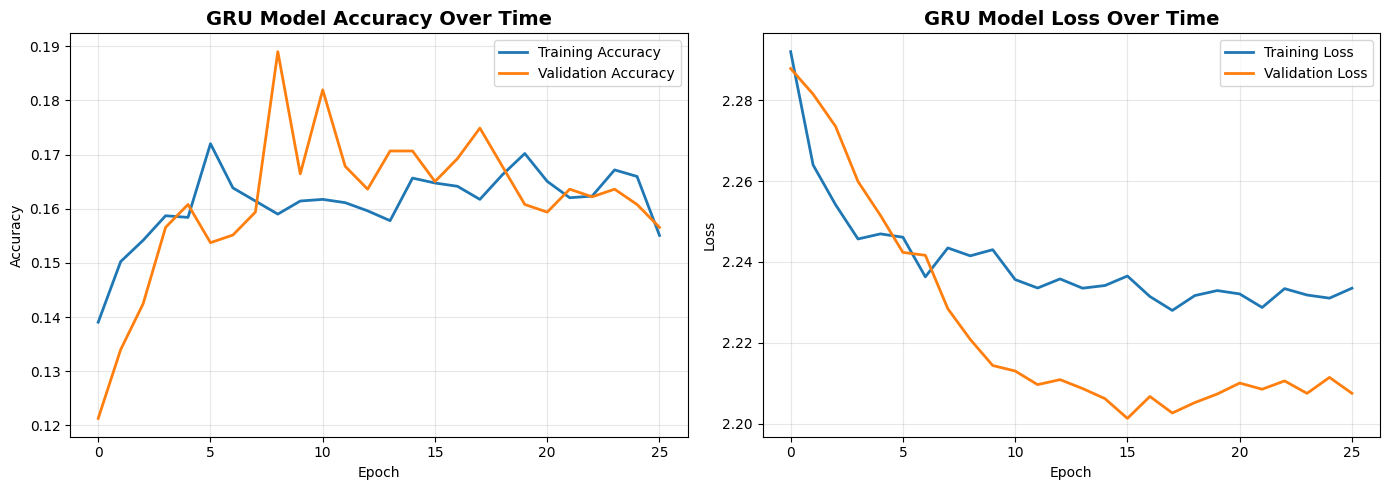

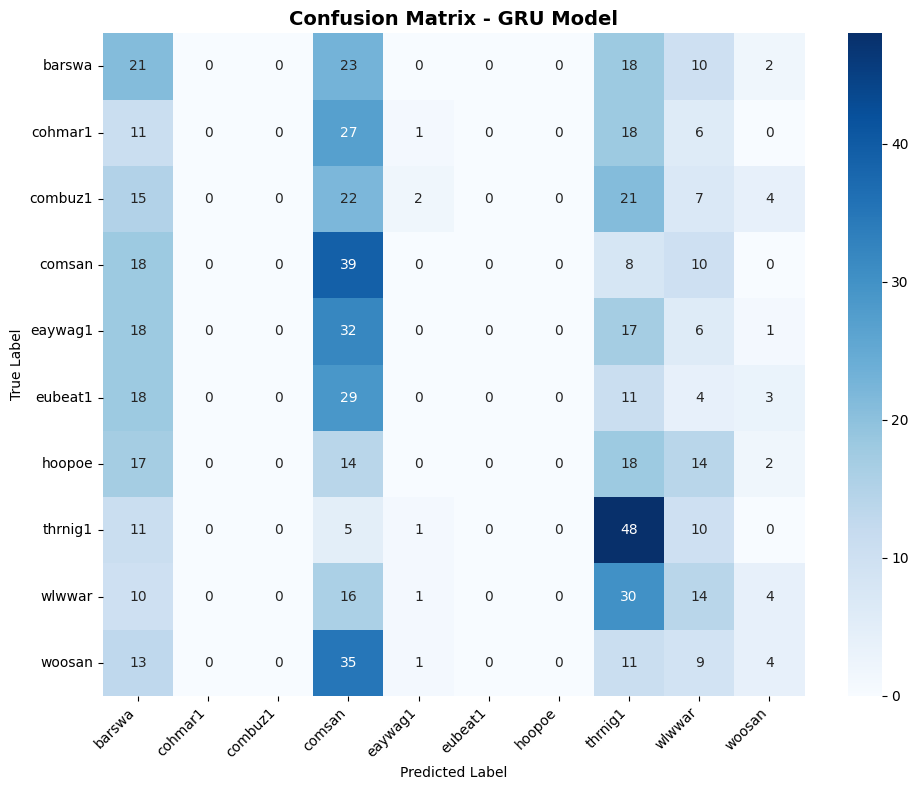

In [ ]:
#visualize(history, best_epoch)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Evalutate
print("\n" + "=" * 70)
print("Model Evaluation")
print("=" * 70 + "\n")

# Get all evaluation metrics (could be more than 2)
eval_results = model.evaluate(X_test, y_test, verbose=0)

# Handle different cases
if isinstance(eval_results, list):
    test_loss = eval_results[0]
    test_accuracy = eval_results[1] if len(eval_results) > 1 else None
else:
    test_loss = eval_results
    test_accuracy = None

print(f"Test Loss: {test_loss:.4f}")
if test_accuracy is not None:
    print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Get predictions
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Show some predictions
print("\n📋 Sample Predictions:")
for i in range(min(5, len(X_test))):
    true_species = label_encoder.inverse_transform([y_test[i]])[0]
    pred_species = label_encoder.inverse_transform([y_pred[i]])[0]
    confidence = y_pred_probs[i][y_pred[i]] * 100

    match = "✓" if true_species == pred_species else "✗"
    print(f"{match} True: {true_species:20s} | Predicted: {pred_species:20s} ({confidence:.1f}% confident)")

# Plot Training History
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_title('GRU Model Accuracy Over Time', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_title('GRU Model Loss Over Time', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#confusion matrix


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - GRU Model', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



# Fit model (RMS)

In [ ]:
import pickle
with open('/content/drive/MyDrive/SYDE 577/BirdClef Models/data/logmel_features_mels_64.pkl', 'rb') as f:
    data = pickle.load(f)

X_data = data['X']
y_labels = data['y']

#print the data
print(f" Data loaded")
print(f"   Features shape: {X_data.shape}")
print(f"   Labels shape: {y_labels.shape}")
print(f"   Number of samples: {len(X_data)}")

# print out species
unique_species = np.unique(y_labels)
num_species = len(unique_species)
print(f"   Number of bird species: {num_species}")
print(f"   Species: {list(unique_species[:10])}")

#encode labels to numbers
print("\n Encoding labels to numbers...")
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)

print(f" Labels encoded!")
print(f"   Example: '{y_labels[0]}' → {y_encoded[0]}")

In [ ]:

model=build_model()

# Early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1,
    start_from_epoch=0
)

# Train
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

best_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1
print(f"\n Best epoch: {best_epoch}")

